In [37]:
# import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

### USDC

In [38]:
# load dataset from csv
usdc = pd.read_csv('usdc.csv')
usdc_model = usdc[usdc['date'] >= '2021-05-18']
usdc.head(5)

,date,mean,median,mean_prev,mean_2,mean_3,mean_4,median_prev,median_2,median_3,median_4
0,2020-12-02,0.015397,0.000673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-03,4.709153,2.975852,0.015397,NaN,NaN,NaN,0.000673,NaN,NaN,NaN
2,2020-12-04,16.669601,11.285359,4.709153,2.362275,NaN,NaN,2.975852,1.488263,NaN,NaN
3,2020-12-05,16.042440,3.843381,16.669601,10.689377,7.131384,NaN,11.285359,7.130606,4.753962,NaN
4,2020-12-06,13.762878,6.880858,16.042440,16.356021,12.473731,9.359148,3.843381,7.564370,6.034864,4.526317


In [39]:
# create train and test data
#features = ['median_prev']
features = ['mean_prev', 'mean_2', 'median_prev', 'median_2', 'median_4']
#features = ['mean_prev', 'mean_2', 'mean_3', 'mean_4', 'median_prev', 'median_2', 'median_3', 'median_4']
label = ['median']
train_df = usdc_model[(usdc_model['date'] < '2021-09-08')]
test_df = usdc_model[usdc_model['date'] >= '2021-09-08']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [40]:
# train xgboost model
reg = XGBRegressor(n_estimators = 600, learning_rate = 0.01, max_depth=6)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=['mae'])
evals_result = reg.evals_result()

[03:26:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:3.35661	validation_1-mae:4.60918
[1]	validation_0-mae:3.32402	validation_1-mae:4.55522
[2]	validation_0-mae:3.29175	validation_1-mae:4.50177
[3]	validation_0-mae:3.25979	validation_1-mae:4.44884
[4]	validation_0-mae:3.22814	validation_1-mae:4.3964
[5]	validation_0-mae:3.1968	validation_1-mae:4.34447
[6]	validation_0-mae:3.16577	validation_1-mae:4.29303
[7]	validation_0-mae:3.13504	validation_1-mae:4.24208
[8]	validation_0-mae:3.1046	validation_1-mae:4.19161
[9]	validation_0-mae:3.07447	validation_1-mae:4.14162
[10]	validation_0-mae:3.04462	validation_1-mae:4.09211
[11]	validation_0-mae:3.0151	validation_1-mae:4.0479
[12]	validation_0-mae:2.98586	validation_1-mae:4.00411
[13]	validation_0-mae:2.95688	validation_1-mae:3.95596
[14]	validation_0-mae:2.92821	validation_1-mae:3.91298
[15]	validation_0-mae:2.89979	validation_1-mae:3.86573
[16]	val

[Text(0, 0, 'Previous Day Mean'),
 Text(0, 0, 'Previous 2 Day Rolling Mean'),
 Text(0, 0, 'Previous 3 Day Rolling Mean'),
 Text(0, 0, 'Previous 4 Day Rolling Mean'),
 Text(0, 0, 'Previous Day Median')]

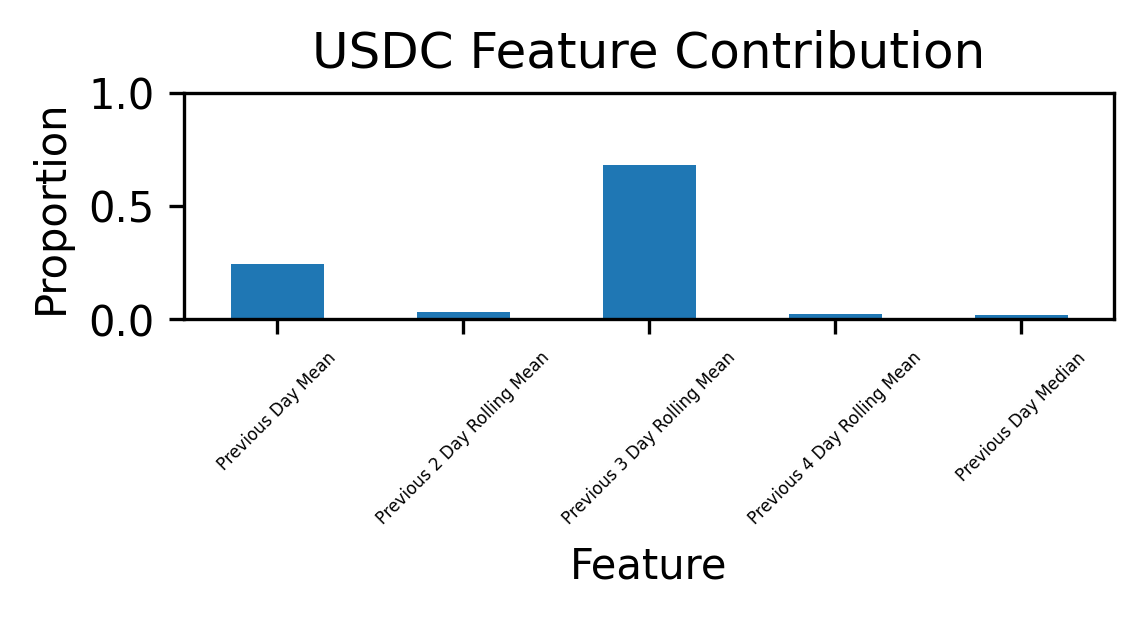

In [41]:
feat_importances = pd.Series(reg.feature_importances_, index=features)
labels = ['Previous Day Mean', 'Previous 2 Day Rolling Mean',
                                          'Previous 3 Day Rolling Mean', 'Previous 4 Day Rolling Mean',
                                          'Previous Day Median', 'Previous 2 Day Rolling Median',
                                          'Previous 3 Day Rolling Median', 'Previous 4 Day Rolling Median']
feature_plot = feat_importances.plot(kind='bar', title='USDC Feature Contribution', xlabel='Feature', 
                      ylabel='Proportion', ylim=[0,1], figsize=(4,1))
feature_plot.set_xticklabels(labels, rotation = 45, fontsize = 4)

Text(500, 0.2, 'Converges to 0.047754')

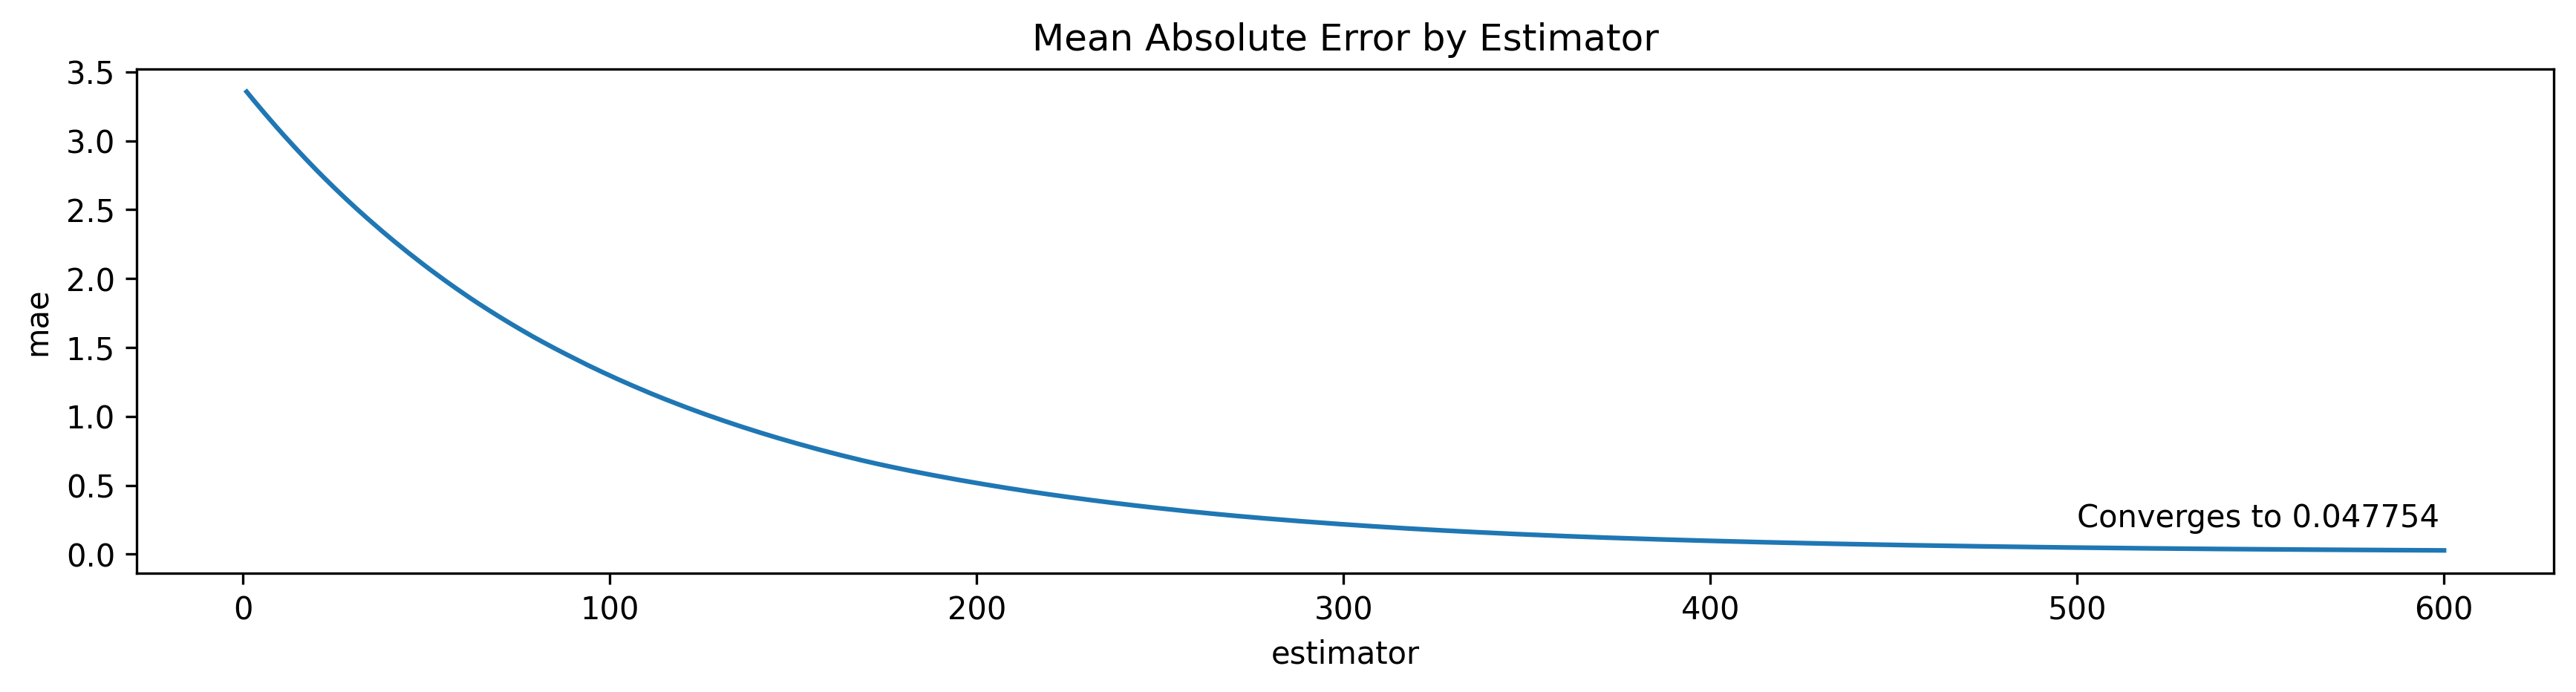

In [42]:
mae_range = range(1, len(evals_result['validation_0']['mae'])+1)
mae_xgb  = pd.DataFrame()
mae_xgb['estimator'] = mae_range 
mae_xgb['mae'] = evals_result['validation_0']['mae']
plt.rcParams.update({'figure.figsize': (14, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=mae_xgb, x='estimator', y='mae')
plt.title("Mean Absolute Error by Estimator")
plt.text(500,.2,'Converges to ' + str(mae_xgb['mae'][499]))

In [43]:
# forecast using xgboost model on testing data
predictions = reg.predict(X_test)

In [44]:
# add predictions to test dataframe
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)
test_df.tail(5)

,date,mean,median,mean_prev,mean_2,mean_3,mean_4,median_prev,median_2,median_3,median_4,predictions
17,2021-09-25,5.056135,4.917059,6.945029,6.581330,6.083639,5.812984,6.983910,6.402759,5.641633,5.521178,7.439458
18,2021-09-26,3.940933,3.934439,5.056135,6.000582,6.072932,5.826763,4.917059,5.950484,5.907526,5.460489,5.977942
19,2021-09-27,5.923547,3.956132,3.940933,4.498534,5.314032,5.539932,3.934439,4.425749,5.278469,5.414254,3.903211
20,2021-09-28,4.555057,4.207087,5.923547,4.932240,4.973538,5.466411,3.956132,3.945285,4.269210,4.947885,4.993963
21,2021-09-29,5.579832,5.550843,4.555057,5.239302,4.806512,4.868918,4.207087,4.081609,4.032552,4.253679,6.317587


Text(0, 0.5, 'Variable Rate')

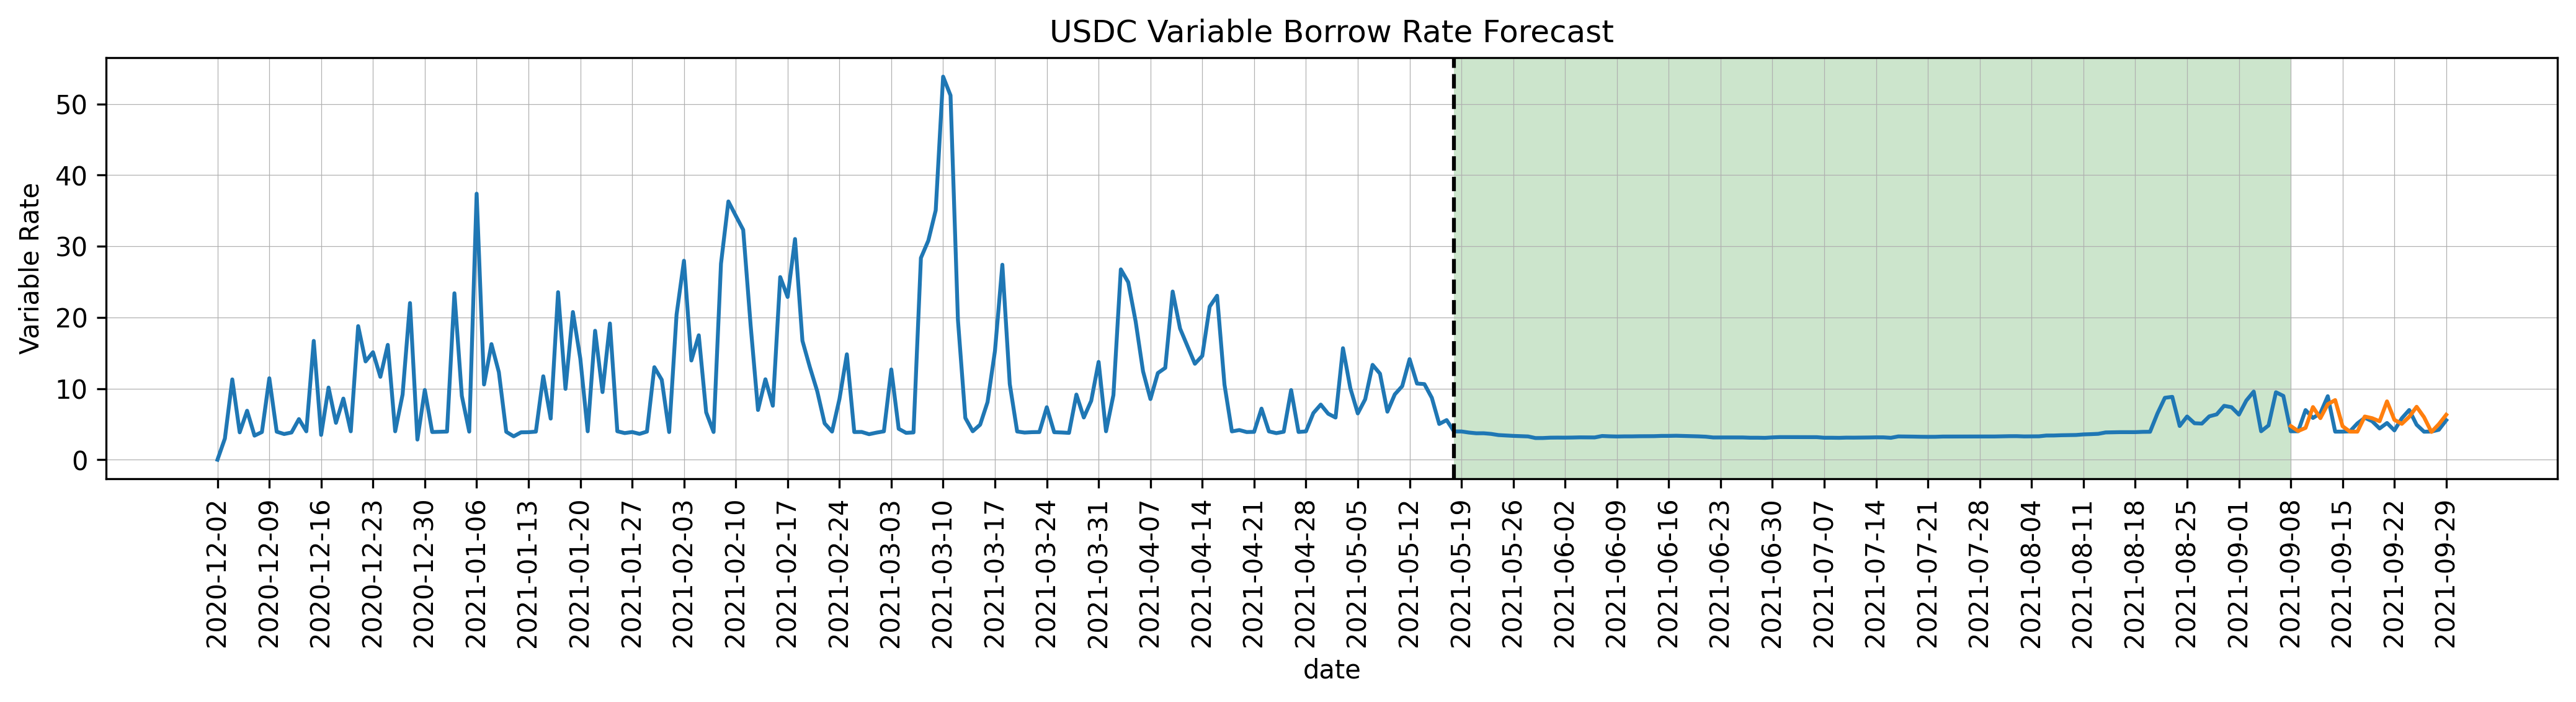

In [45]:
# plot the forecast with the actual values
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=usdc, x='date', y='median')
sns.lineplot(data=test_df, x='date', y='predictions')
ax.set_xticks(ax.get_xticks()[::7])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
ax.axvspan('2021-05-18', '2021-09-08', facecolor='green', alpha=.2)
plt.axvline('2021-05-18', color='k', linestyle='--')
plt.title("USDC Variable Borrow Rate Forecast")
plt.ylabel('Variable Rate')

### WETH

In [62]:
# load dataset from csv
weth = pd.read_csv('weth.csv')
weth.head(5)

,date,mean,median,mean_prev,mean_2,mean_3,mean_4,median_prev,median_2,median_3,median_4
0,2020-11-30,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-01,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,2020-12-02,0.744340,0.230189,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN
3,2020-12-03,0.028907,0.000672,0.744340,0.372170,0.248113,NaN,0.230189,0.115094,0.076730,NaN
4,2020-12-04,0.081389,0.060041,0.028907,0.386624,0.257749,0.193312,0.000672,0.115430,0.076954,0.057715


In [63]:
# create train and test data
#features = ['median_prev']
#features = ['mean_prev', 'mean_2', 'median_prev', 'median_2', 'median_4']
features = ['mean_prev', 'mean_2', 'mean_3', 'mean_4', 'median_prev', 'median_2', 'median_3', 'median_4']
label = ['median']
train_df = weth[(weth['date'] < '2021-07-01')]
test_df = weth[weth['date'] >= '2021-07-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [64]:
# train xgboost model
reg = XGBRegressor(n_estimators = 600, learning_rate = 0.01, max_depth=6)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=['mae'])
evals_result = reg.evals_result()

[04:05:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.88005	validation_1-mae:0.103969
[1]	validation_0-mae:0.871566	validation_1-mae:0.102897
[2]	validation_0-mae:0.863164	validation_1-mae:0.101835
[3]	validation_0-mae:0.854843	validation_1-mae:0.100782
[4]	validation_0-mae:0.846605	validation_1-mae:0.099739
[5]	validation_0-mae:0.83845	validation_1-mae:0.098996
[6]	validation_0-mae:0.830375	validation_1-mae:0.09826
[7]	validation_0-mae:0.822377	validation_1-mae:0.097531
[8]	validation_0-mae:0.814465	validation_1-mae:0.096502
[9]	validation_0-mae:0.806631	validation_1-mae:0.095763
[10]	validation_0-mae:0.79888	validation_1-mae:0.095024
[11]	validation_0-mae:0.791199	validation_1-mae:0.094298
[12]	validation_0-mae:0.783613	validation_1-mae:0.093374
[13]	validation_0-mae:0.776085	validation_1-mae:0.092654
[14]	validation_0-mae:0.768659	validation_1-mae:0.092029
[15]	validation_0-mae:0.761305	v

[Text(0, 0, 'Previous Day Mean'),
 Text(0, 0, 'Previous 2 Day Rolling Mean'),
 Text(0, 0, 'Previous 3 Day Rolling Mean'),
 Text(0, 0, 'Previous 4 Day Rolling Mean'),
 Text(0, 0, 'Previous Day Median'),
 Text(0, 0, 'Previous 2 Day Rolling Median'),
 Text(0, 0, 'Previous 3 Day Rolling Median'),
 Text(0, 0, 'Previous 4 Day Rolling Median')]

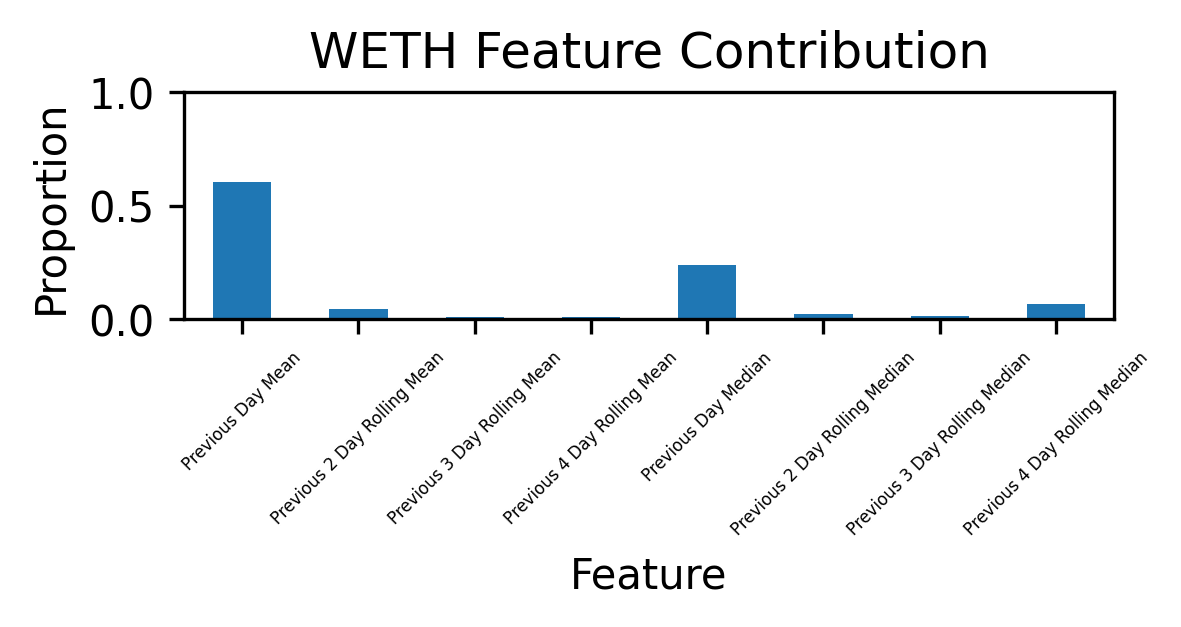

In [65]:
feat_importances = pd.Series(reg.feature_importances_, index=features)
labels = ['Previous Day Mean', 'Previous 2 Day Rolling Mean',
                                          'Previous 3 Day Rolling Mean', 'Previous 4 Day Rolling Mean',
                                          'Previous Day Median', 'Previous 2 Day Rolling Median',
                                          'Previous 3 Day Rolling Median', 'Previous 4 Day Rolling Median']
feature_plot = feat_importances.plot(kind='bar', title='WETH Feature Contribution', xlabel='Feature', 
                      ylabel='Proportion', ylim=[0,1], figsize=(4,1))
feature_plot.set_xticklabels(labels, rotation = 45, fontsize = 4)

Text(500, 0.2, 'Converges to 0.0366')

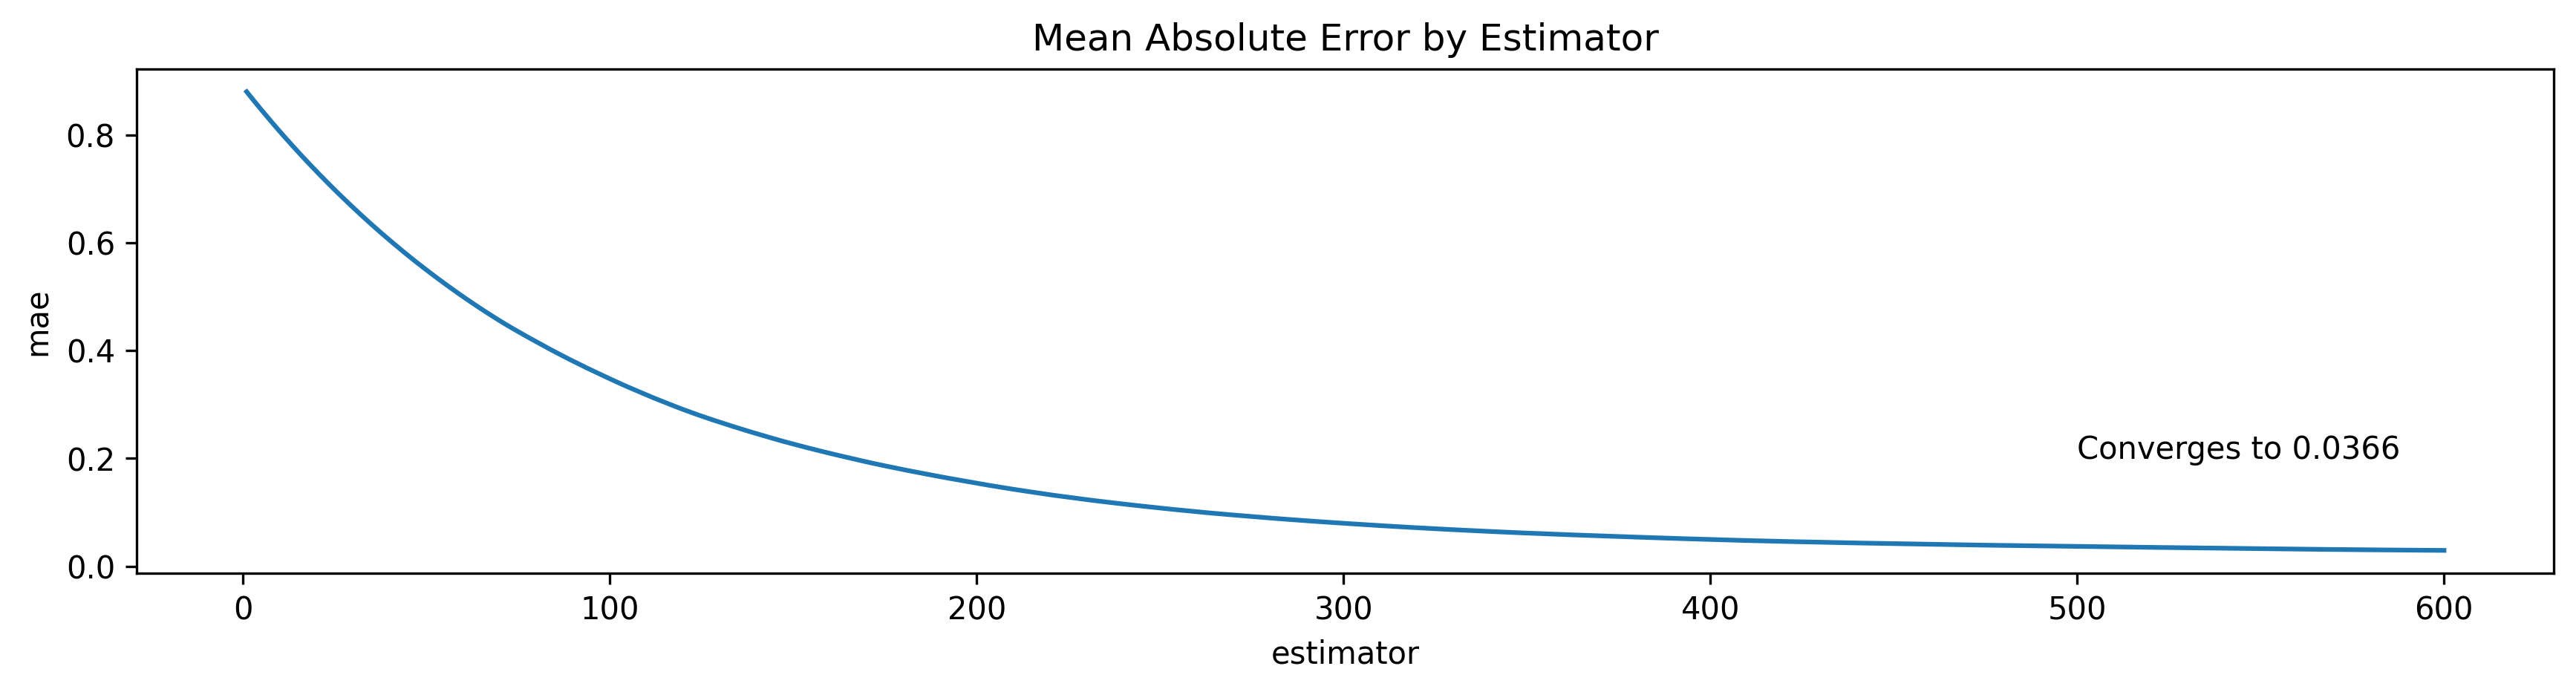

In [66]:
mae_range = range(1, len(evals_result['validation_0']['mae'])+1)
mae_xgb  = pd.DataFrame()
mae_xgb['estimator'] = mae_range 
mae_xgb['mae'] = evals_result['validation_0']['mae']
plt.rcParams.update({'figure.figsize': (14, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=mae_xgb, x='estimator', y='mae')
plt.title("Mean Absolute Error by Estimator")
plt.text(500,.2,'Converges to ' + str(mae_xgb['mae'][499]))

In [67]:
# forecast using xgboost model on testing data
predictions = reg.predict(X_test)

In [68]:
# add predictions to test dataframe
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)
test_df.tail(5)

,date,mean,median,mean_prev,mean_2,mean_3,mean_4,median_prev,median_2,median_3,median_4,predictions
86,2021-09-25,0.249493,0.250222,0.252699,0.255297,0.259643,0.264088,0.252484,0.256312,0.260404,0.264207,0.303284
87,2021-09-26,0.256277,0.257382,0.249493,0.251096,0.253363,0.257106,0.250222,0.251353,0.254282,0.257859,0.309749
88,2021-09-27,0.252821,0.253181,0.256277,0.252885,0.252823,0.254091,0.257382,0.253802,0.253363,0.255057,0.356423
89,2021-09-28,0.251800,0.250257,0.252821,0.254549,0.252864,0.252822,0.253181,0.255282,0.253595,0.253317,0.322853
90,2021-09-29,0.251220,0.250147,0.251800,0.252311,0.253633,0.252598,0.250257,0.251719,0.253607,0.252760,0.309749


Text(0, 0.5, 'Variable Rate')

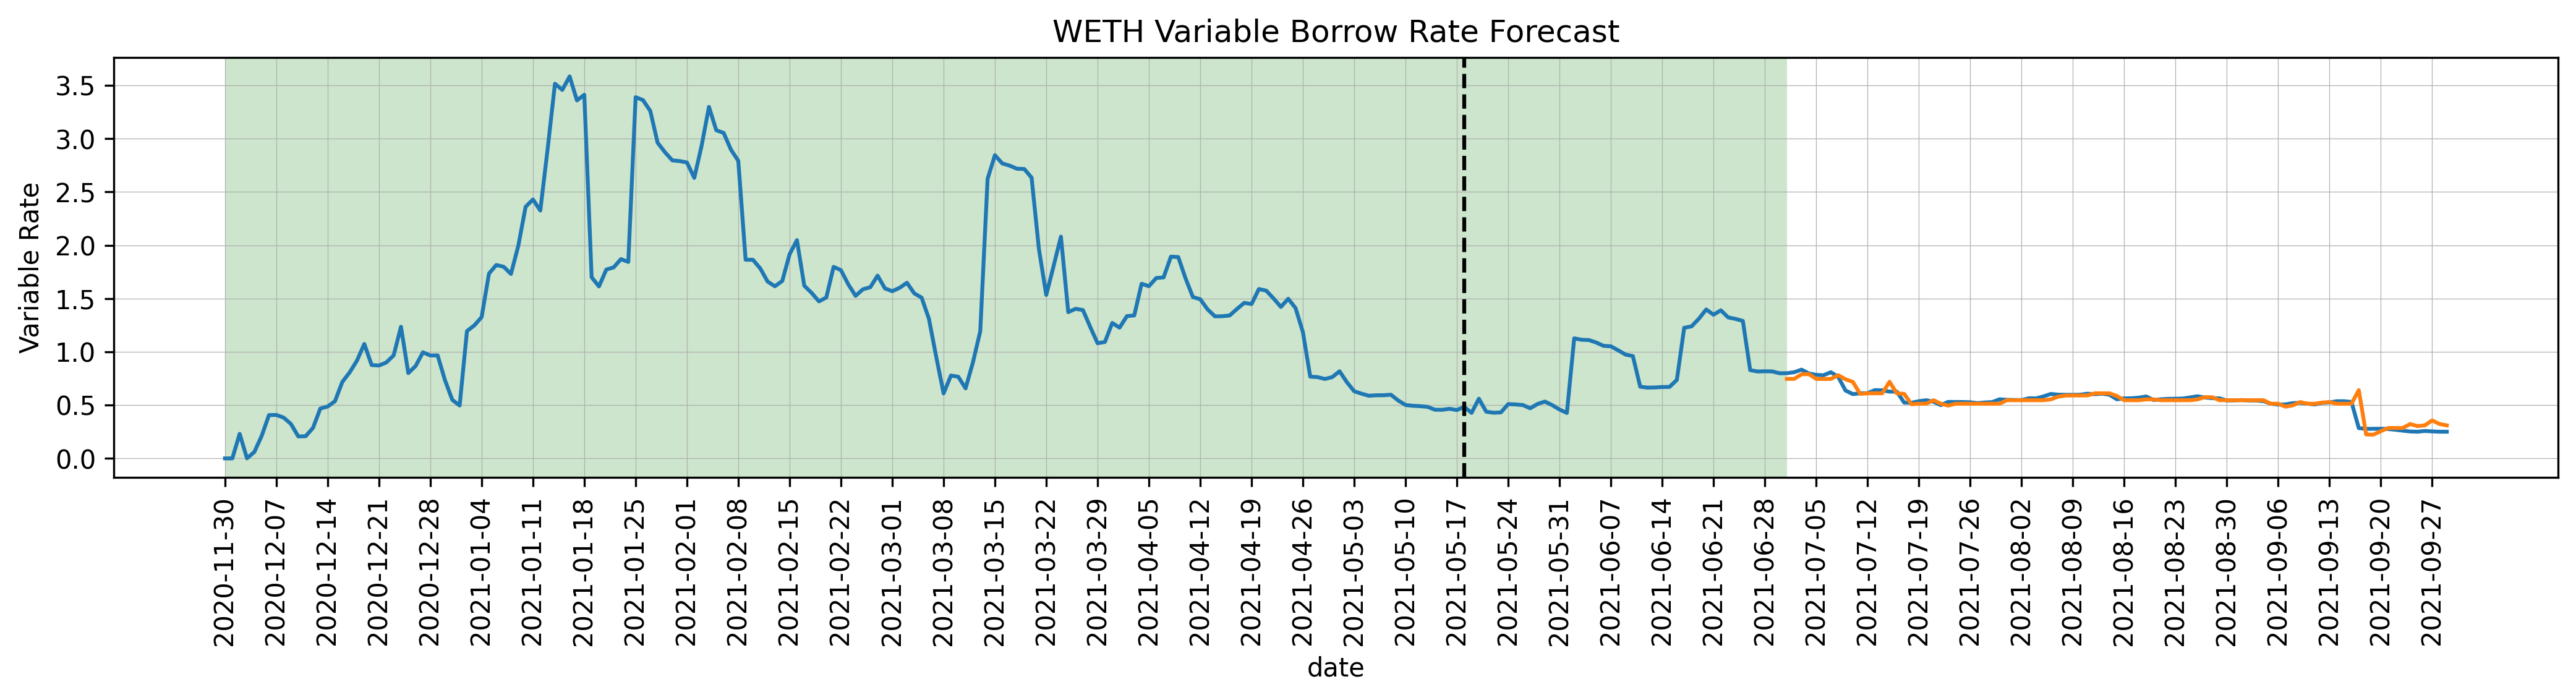

In [69]:
# plot the forecast with the actual values
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weth, x='date', y='median')
sns.lineplot(data=test_df, x='date', y='predictions')
ax.set_xticks(ax.get_xticks()[::7])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
plt.axvline('2021-05-18', color='k', linestyle='--')
ax.axvspan('2020-11-30', '2021-07-01', facecolor='green', alpha=.2)
plt.title("WETH Variable Borrow Rate Forecast")
plt.ylabel('Variable Rate')